## One dimensional example of a He atom

$$
\newcommand{\bvec}[1]{{\boldsymbol #1}}
\newcommand{\norm}[1]{{\lVert#1\rVert}}
\newcommand{\bra}[1]{{\langle#1\rvert}}
\newcommand{\ket}[1]{{\lvert#1\rangle}}
\newcommand{\RR}{\mathbb{R}}
\newcommand{\vr}{\bvec{r}}
\newcommand{\vx}{\bvec{x}}
\newcommand{\ud}{\,\mathrm{d}}
$$


Soft Coulomb potential with Gaussian pseudo charges in 1D.  Dense linear algebra is used for simplicity

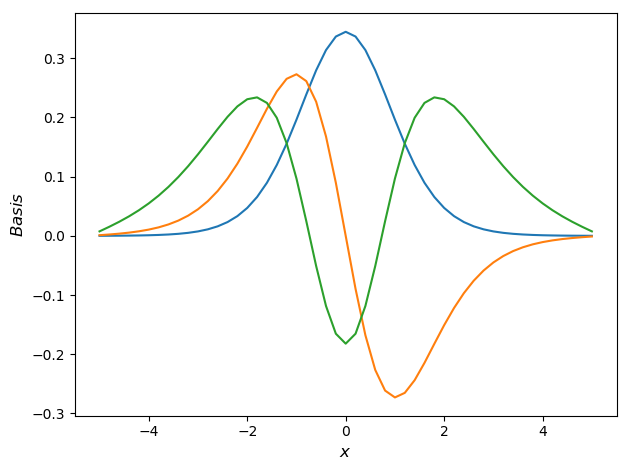

PyObject Text(26,0.5,'$Basis$')

In [121]:
using LinearAlgebra

dx = 0.2

κ = 0.3
ϵ_0 = 1.0

Natoms = 1
R = [0.0]
Z = [2.0]
sigma = [1.0]

vC(x) = 1.0 / (ϵ_0 * sqrt(x^2 + κ^2))

Ls = 5.0

gridpos = collect(range(-Ls,stop=Ls,step=dx))
Ns = length(gridpos)

vC_mat = [vC(gridpos[i]-gridpos[j]) for i in 1:Ns, j in 1:Ns]

rhoa = zeros(Ns)
for j = 1 : Natoms
    dist = gridpos .- R[j]
    @. rhoa = rhoa - Z[j] / sqrt(2*pi*sigma[j]^2) * (exp(-0.5*(dist/sigma[j])^2 ))
end

Vext = vC_mat * rhoa * dx

Lap = 1.0 / (2.0*dx^2) * diagm(-1=>-ones(Ns-1),0=>2.0*ones(Ns),1=>-ones(Ns-1))

H_atom = Lap + diagm(0=>Vext)

eigH = eigen(H_atom)

Nb = 3
Phi = eigH.vectors[:,1:Nb]

using PyPlot

figure(1)
plot(gridpos,Phi[:,1:Nb])

xlabel(L"x")
ylabel(L"Basis")

In [122]:
# Construct the 2-body Hamiltonian (by brute force)

Iden = Matrix(1.0I,Ns,Ns)

H = kron(H_atom,Iden) + kron(Iden,H_atom) + diagm(0=>vC_mat[:])

Basis = kron(Phi,Phi)

H_proj = Basis'*(H*Basis)
# Enforce symmetry to make sure ordering of the eigenvalues
H_proj = 0.5*(H_proj+H_proj')

eigH_proj = eigen(H_proj)

Psi = Basis * eigH_proj.vectors

println("Eigenvalues = ", eigH_proj.values)


Eigenvalues = [-3.84378, -3.49808, -2.88883, -2.75144, -2.50107, -1.99458, -1.93104, -1.27822, -0.776871]


Ground state is symmetric (spatial part), and corresponds to a spin singlet configuration. 

**Note**: There is no theorem guaranteeing this statement. But this is usually the case in chemistry. In fact, depending on the shape of the Coulomb interaction, the spatial part of the ground state may become anti-symmetric as well.

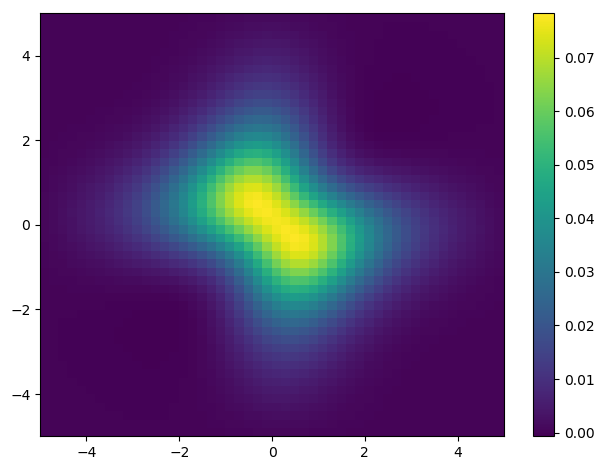

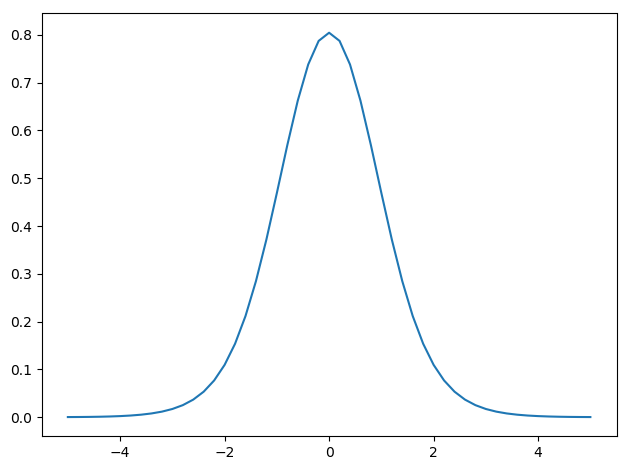

Sum of electron density  1.9999999999999998


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc294ae6f60>

In [123]:
ind = 1
figure(1)
pcolor(gridpos,gridpos,reshape(Psi[:,ind],(Ns,Ns)))
colorbar()

figure(2)
Psi_nd = reshape(Psi[:,ind],Ns,Ns)
rho = 2.0*(sum(abs.(Psi_nd.^2), dims=2)) / dx
println("Sum of electron density  ", sum(rho*dx))
plot(gridpos,rho)

First excited state is anti-symmetric (spatial part), and corresponds to a spin triplet configuration.

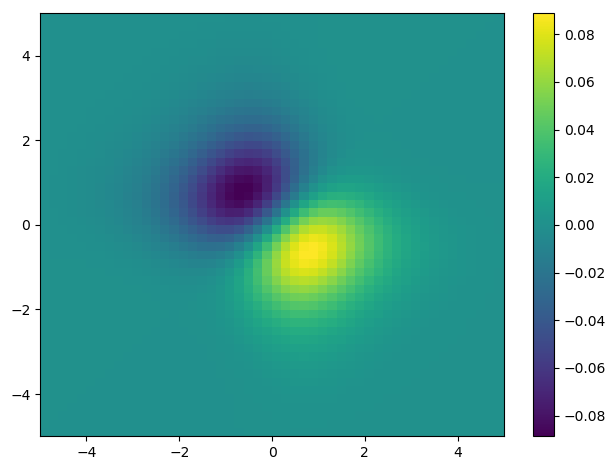

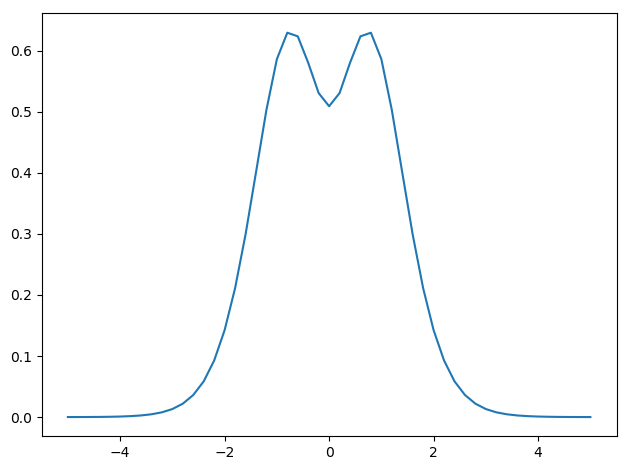

Sum of electron density  2.0


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc2948d44a8>

In [124]:
ind = 2
figure(1)
pcolor(gridpos,gridpos,reshape(Psi[:,ind],(Ns,Ns)))
colorbar()

figure(2)
Psi_nd = reshape(Psi[:,ind],Ns,Ns)
rho = 2.0*(sum(abs.(Psi_nd.^2), dims=2)) / dx
println("Sum of electron density  ", sum(rho*dx))
plot(gridpos,rho)

## Hartree-Fock approximation 


For the spin singlet configuration, the spatial part of the wavefunction is symmetric.  In the Hartree-Fock approximation, the spatial part of the wavefunction is 

$$\varphi(\vr_1,\vr_2) = \psi(\vr_1)\psi(\vr_2).$$

**Exercise**: Show that the total energy is

$$E = \int |\nabla \psi|^2 + \int V_{\text{ext}} \rho + \frac14 \int v_C(\vr,\vr')\rho(\vr)\rho(\vr') \ud \vr \ud \vr',$$

where

$$\rho(\vr) = 2 |\psi(\vr)|^2.$$

Also the corresponding Hartree-Fock equation is

$$\left(-\frac12 \Delta + V_{\text{ext}} + \frac12 \int v_C(\vr,\vr') \rho(\vr') \ud \vr'\right) \psi(\vr) = \varepsilon \psi(\vr),$$

and the total energy is

$$E = 2\varepsilon -  \frac14 \int v_C(\vr,\vr')\rho(\vr)\rho(\vr') \ud \vr \ud \vr'.$$

The Hartree-Fock equation can be solved by obtaining the self-consistent solution. We use the basis given by the atomic orbitals
at each step.

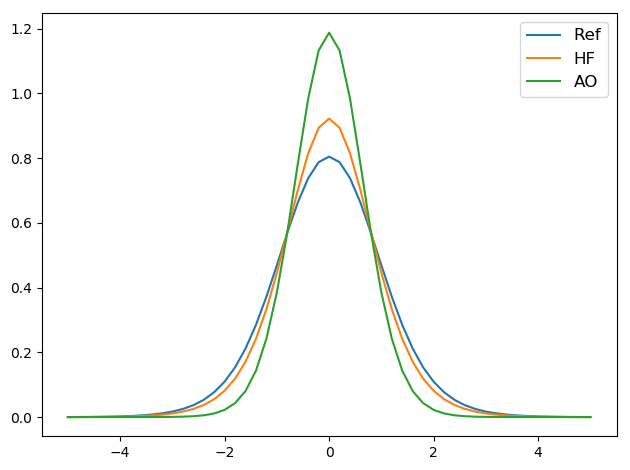

Iter = 98, err = 9.738166164612817e-7
E_hf     = -3.705382552140337, E_ground = -3.8437808066803187


PyObject <matplotlib.legend.Legend object at 0x7fc294376470>

In [144]:
function HF_ground(rho0) 
    tol = 1e-6

    rho = rho0
    err = 1.0
    iter = 0
    alpha = 0.1
    E_hf = 0.0
    while( err > tol )
        Vhar = 0.5 * vC_mat * rho * dx
        H_hf = Lap + diagm(0=>(Vext+Vhar)) 
        H_hf_proj = Phi'*(H_hf*Phi)
        H_hf_proj = (H_hf_proj+H_hf_proj')*0.5

        eigH_hf_proj = eigen(H_hf_proj)
        psi_hf = Phi * eigH_hf_proj.vectors[:,1]
        rhonew = 2.0 * psi_hf.^2 / dx

        E_hf = 2 * eigH_hf_proj.values[1] - 0.5 * sum(Vhar .* rho * dx)

        err = norm(rho - rhonew) / norm(rho)
        iter = iter + 1
        # println("Iter = ", iter, ", err = ", err)
        rho = (1-alpha) * rho + alpha * rhonew
    end
    println("Iter = ", iter, ", err = ", err)
    return (E_hf, rho)
end

# initial guess from atomic orbitals
rho0 = 2.0 * Phi[:,1].^2 / dx

(E_hf, rho_hf) = HF_ground(rho0)
println("E_hf     = ", E_hf, ", E_ground = ", eigH_proj.values[1])
Psi_nd = reshape(Psi[:,1],Ns,Ns)
rho = 2.0*(sum(abs.(Psi_nd.^2), dims=2)) / dx

plot(gridpos, [rho rho_hf rho0])
legend(("Ref","HF","AO"))

For the spin triplet configuration $\ket{\uparrow\uparrow}$, the spatial part of the wavefunction is anti-symmetric.  In the Hartree-Fock approximation, the spatial part of the wavefunction is the Slater determinant given by $\psi_1,\psi_2$

**Exercise**: Show that the total energy is

$$E = \frac12\sum_{i=1}^2\int |\nabla \psi_i|^2 + \int V_{\text{ext}} \rho + \frac12 \int v_C(\vr,\vr')\rho(\vr)\rho(\vr') \ud \vr \ud \vr'-\frac12 \int v_C(\vr,\vr') |P(\vr,\vr')|^2 \ud \vr \ud \vr',$$

where

$$P(\vr,\vr')= \psi_1(\vr)\psi_1^*(\vr') + \psi_2(\vr)\psi_2^*(\vr'), \quad \rho(\vr) = P(\vr,\vr).$$

Also the corresponding Hartree-Fock equation is

$$\left(-\frac12 \Delta + V_{\text{ext}} + \int v_C(\vr,\vr') \rho(\vr') \ud \vr'\right) \psi_i(\vr) - \int v_C(\vr,\vr') P(\vr,\vr') \psi_i(\vr') \ud \vr'  = \varepsilon_i \psi_i(\vr),$$

and the total energy is

$$E = \varepsilon_1 + \varepsilon_2 -  \frac12 \int v_C(\vr,\vr')\rho(\vr)\rho(\vr') \ud \vr \ud \vr' + \frac12 \int v_C(\vr,\vr') |P(\vr,\vr')|^2 \ud \vr \ud \vr'.$$

The Hartree-Fock equation can be solved by obtaining the self-consistent solution. We use the basis given by the atomic orbitals
at each step.

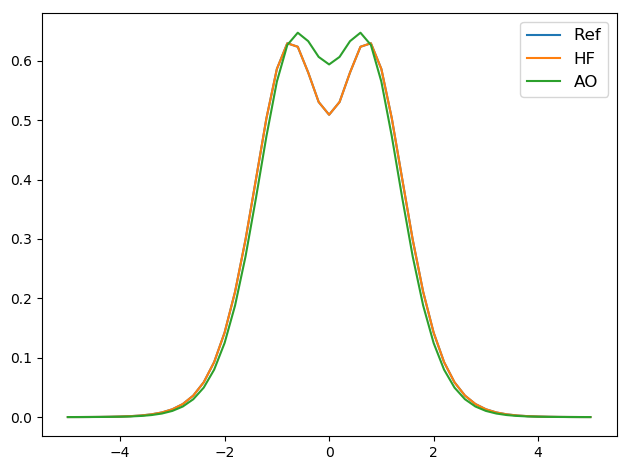

Iter = 95, err = 9.888135849497966e-7
E_hf     = -3.4980455635626213, E_excited = -3.4980797567220523


PyObject <matplotlib.legend.Legend object at 0x7fc293f37c88>

In [164]:
function HF_excited(P0) 
    tol = 1e-6

    P = P0
    rho = diag(P)
    
    err = 1.0
    iter = 0
    alpha = 0.1
    E_hf = 0.0
    
    Vhar = vC_mat * rho * dx
    Hfock = - vC_mat .* P * dx
    H_hf = Lap + diagm(0=>(Vext+Vhar)) + Hfock
    while( err > tol )

        H_hf_proj = Phi'*(H_hf*Phi)
        H_hf_proj = (H_hf_proj+H_hf_proj')*0.5

        eigH_hf_proj = eigen(H_hf_proj)
        psi_hf = Phi * eigH_hf_proj.vectors[:,1:2]
        
        P = psi_hf * psi_hf' / dx
        rho = diag(P)
        Vhar = vC_mat * rho * dx
        Hfock = - vC_mat .* P * dx
        H_hf_new = Lap + diagm(0=>(Vext+Vhar)) + Hfock

        E_hf = sum(eigH_hf_proj.values[1:2]) - 0.5 * sum(Vhar .* rho * dx) -
            0.5 * tr(psi_hf'*(Hfock*psi_hf))


        # Note: this is NOT the operator 2-norm, but the Frobenius norm
        err = norm(H_hf - H_hf_new) / norm(H_hf)
        iter = iter + 1
        # println("Iter = ", iter, ", err = ", err)
        H_hf = (1-alpha) * H_hf + alpha * H_hf_new
    end
    println("Iter = ", iter, ", err = ", err)
    return (E_hf, rho)
end

# initial guess from atomic orbitals

P0 = (Phi[:,1] * Phi[:,1]' + Phi[:,2] * Phi[:,2]') / dx

rho0 = diag(P0)
(E_hf, rho_hf) = HF_excited(P0)
println("E_hf     = ", E_hf, ", E_excited = ", eigH_proj.values[2])
Psi_nd = reshape(Psi[:,2],Ns,Ns)
rho = 2.0*(sum(abs.(Psi_nd.^2), dims=2)) / dx

plot(gridpos, [rho rho_hf rho0])
legend(("Ref","HF","AO"))